In [40]:
from datetime import datetime
from functools import partial
import glob
import gc
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.optimizer import Optimizer
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, _LRScheduler
import torch.nn.utils.weight_norm as weightNorm
import torch.nn.init as init
from torch.nn.parallel.data_parallel import data_parallel

from models.model import *
import torchvision.models as models

from utils.transform import *

from tensorboardX import SummaryWriter
from apex import amp
from ranger import *

import albumentations
from albumentations import torch as AT

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

In [2]:
############################################################################## Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

# If you try to use original LyftDataset Class, you will get missing table error
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

level5data = LyftTestDataset(data_path='.', json_path='/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/data', verbose=True)

9 category,
17 attribute,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
1 map,
Done loading in 1.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.5 seconds.


In [3]:
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)

In [4]:
SIZE = 336

def transform_train(image, mask):
    if random.random() < 0.5:
        image = albumentations.RandomRotate90(p=1)(image=image)['image']
        mask = albumentations.RandomRotate90(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.Transpose(p=1)(image=image)['image']
        mask = albumentations.Transpose(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.VerticalFlip(p=1)(image=image)['image']
        mask = albumentations.VerticalFlip(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.HorizontalFlip(p=1)(image=image)['image']
        mask = albumentations.HorizontalFlip(p=1)(image=mask)['image']

    # if random.random() < 0.5:
    #     image = albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.15, rotate_limit=45, p=1)(image=image)['image']
    #     mask = albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.15, rotate_limit=45, p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.RandomBrightness(0.1)(image=image)['image']
        image = albumentations.RandomContrast(0.1)(image=image)['image']
        image = albumentations.Blur(blur_limit=3)(image=image)['image']

    # if random.random() < 0.5:
    #     image = albumentations.Cutout(num_holes=1, max_h_size=32, max_w_size=32, p=1)(image)
    #     mask = albumentations.Cutout(num_holes=1, max_h_size=32, max_w_size=32, p=1)(mask)

    return image, mask

def transform_valid(image, mask):
    # if random.random() < 0.5:
    #     image = albumentations.RandomRotate90(p=1)(image=image)['image']
    #     mask = albumentations.RandomRotate90(p=1)(image=mask)['image']

    # if random.random() < 0.5:
    #     image = albumentations.Transpose(p=1)(image=image)['image']
    #     mask = albumentations.Transpose(p=1)(image=mask)['image']

    # if random.random() < 0.5:
    #     image = albumentations.VerticalFlip(p=1)(image=image)['image']
    #     mask = albumentations.VerticalFlip(p=1)(image=mask)['image']

    if random.random() < 0.5:
        image = albumentations.HorizontalFlip(p=1)(image=image)['image']
        mask = albumentations.HorizontalFlip(p=1)(image=mask)['image']

    return image, mask

def transform_test(image):
    
    image_hard = image.copy()
    image_simple = image.copy()

    if random.random() < 0.5:
        image_hard = albumentations.RandomBrightness(0.1)(image=image_hard)['image']
        image_hard = albumentations.RandomContrast(0.1)(image=image_hard)['image']
        image_hard = albumentations.Blur(blur_limit=3)(image=image_hard)['image']

    return image_simple, image_hard

# Get sample_tokens

In [5]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

# sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
all_sample_tokens,scene_len = [],[]
for sample_token in tqdm_notebook(df.first_sample_token.values):
    i = 0
    while sample_token:
        all_sample_tokens.append(sample_token)
        sample = level5data.get("sample", sample_token)
        sample_token = sample["next"]
        i += 1
    scene_len.append(i)
#     print(len(all_sample_tokens[-1]))
    
print('Total number of tokens=',len(all_sample_tokens))


Total number of tokens= 27468


In [6]:
class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, sample_token, test_data_folder=None, img_size=336):
        self.sample_token = sample_token
        self.test_data_folder = test_data_folder
        self.type = type
        self.img_size = img_size

    def __len__(self):
        return len(self.sample_token)

    def __getitem__(self, idx):
        
        sample_token = self.sample_token[idx]
        
        input_filepath = os.path.join(self.test_data_folder,f"{sample_token}_input.png")
        map_filepath = os.path.join(self.test_data_folder,f"{sample_token}_map.png")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
 
        im = np.concatenate((im, map_im), axis=2)

        im, _ = transform_test(im) # im_simple, im_hard
        
        im = torch.from_numpy(im.transpose(2,0,1))

        return im, sample_token

In [7]:
class_height = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}

class_width = {'animal':0.36,'bicycle':0.63,'bus':2.96,'car':1.93,'emergency_vehicle':2.45,'motorcycle':0.96,
                'other_vehicle':2.79,'pedestrian':0.77,'truck':2.84}

class_len = {'animal':0.73,'bicycle':1.76,'bus':12.34,'car':4.76,'emergency_vehicle':6.52,'motorcycle':2.35,
                'other_vehicle':8.20,'pedestrian':0.81,'truck':10.24}



test_data_folder = "/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/bev_data_with_map/"

test_input_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_input.png")))
test_target_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_target.png")))

test_dataset = BEVImageDataset(sample_token=all_sample_tokens, test_data_folder=test_data_folder, img_size=SIZE)

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
background_threshold = 40

def calc_detection_box(prediction_opened,class_probability):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes


def open_preds(predictions_non_class0):

    predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

    for i, p in enumerate(tqdm(predictions_non_class0)):
        thresholded_p = (p > background_threshold).astype(np.uint8)
        predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
        
    return predictions_opened

def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [9]:
def get_unet_model(model_name="efficient-b3", IN_CHANNEL=3, NUM_CLASSES=2, SIZE=336):
    model = model_iMet(model_name, IN_CHANNEL, NUM_CLASSES, SIZE)
    
    # Optional, for multi GPU training and inference
    # model = nn.DataParallel(model)
    return model

# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

test_batch_size = 64

In [10]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=os.cpu_count()*2)

# Inference with efficientnet-b3 and seresnext_101

In [11]:
checkpoint_filename_b3 = "unet_checkpoint_b3/unet_checkpoint_b3.pth"
checkpoint_filepath_b3 = os.path.join("/media/jionie/my_disk/Kaggle/Lyft/model/unet/", checkpoint_filename_b3)

model_b3 = get_unet_model(model_name="efficientnet-b3", IN_CHANNEL=3, NUM_CLASSES=len(classes)+1, SIZE=SIZE)
model_b3.load_pretrain(checkpoint_filepath_b3)
model_b3 = model_b3.to(device)

Loaded pretrained weights for efficientnet-b3


In [ ]:
checkpoint_filename_seresnext101 = "unet_checkpoint_seresnext101/seresnext101_unet_checkpoint.pth"
checkpoint_filepath_seresnext101 = os.path.join("/media/jionie/my_disk/Kaggle/Lyft/model/unet/", checkpoint_filename_seresnext101)

model_seresnext101 = get_unet_model(model_name="seresnext101", IN_CHANNEL=3, NUM_CLASSES=len(classes)+1, SIZE=SIZE)
model_seresnext101.load_pretrain(checkpoint_filepath_seresnext101)
model_seresnext101 = model_seresnext101.to(device)

In [12]:
checkpoint_filename_unet_reference = "unet_reference/seresnext101_unet_checkpoint.pth"
checkpoint_filepath_unet_reference = os.path.join("/media/jionie/my_disk/Kaggle/Lyft/model/unet/", checkpoint_filename_seresnext101)

model_seresnext101 = get_unet_model(model_name="seresnext101", IN_CHANNEL=3, NUM_CLASSES=len(classes)+1, SIZE=SIZE)
model_seresnext101.load_pretrain(checkpoint_filepath_seresnext101)
model_seresnext101 = model_seresnext101.to(device)

In [13]:
sample_tokens = []
detection_boxes = []
detection_scores = []
detection_classes = []

print("Inference")

with torch.no_grad():
    
    torch.cuda.empty_cache()

    for test_batch_i, (X, sample_ids) in enumerate(test_dataloader):

        model_b3.eval()
        model_seresnext101.eval()

        sample_tokens.extend(sample_ids)

        X = X.to(device).float()  # [N, 3, H, W]
        prediction_b3, _ = model_b3(X)  # [N, 2, H, W]
        prediction_seresnext101, _ = model_seresnext101(X)  # [N, 2, H, W]
        
        prediction = (prediction_b3 + prediction_seresnext101) / 2
        
        prediction = F.softmax(prediction, dim=1).cpu().numpy()
        
        predictions = np.round(prediction*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:, 0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i], predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)

Inference


/home/jionie/py3env/lib/python3.6/site-packages/torch/nn/functional.py:2622: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Total amount of boxes: 686701


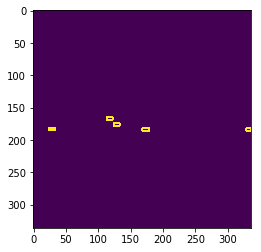

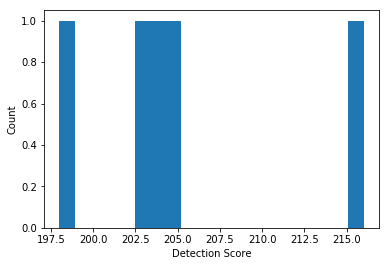

In [14]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

In [15]:
# pred_box3ds = []

# print("Generating world boxes")

# # This could use some refactoring..
# for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in zip(sample_tokens, detection_boxes, detection_scores, detection_classes):

#     sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
#     sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

#     # Add Z dimension
#     sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

#     sample = level5data.get("sample", sample_token)
#     sample_lidar_token = sample["data"]["LIDAR_TOP"]
#     lidar_data = level5data.get("sample_data", sample_lidar_token)
#     lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
#     ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
#     ego_translation = np.array(ego_pose['translation'])

#     global_from_car = transform_matrix(ego_pose['translation'],
#                                        Quaternion(ego_pose['rotation']), inverse=False)

#     car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


#     global_from_voxel = np.dot(global_from_car, car_from_voxel)
#     sample_boxes = transform_points(sample_boxes, global_from_voxel)

#     # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
#     # the same height as the ego vehicle.
#     sample_boxes[2,:] = ego_pose["translation"][2]


#     # (3, N*4) -> (N, 4, 3)
#     sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     # box_height, width, len
#     box_height = np.array([class_height[cls] for cls in sample_detection_class])
#     box_width = np.array([class_width[cls] for cls in sample_detection_class])
#     box_len = np.array([class_len[cls] for cls in sample_detection_class])

#     # Note: Each of these boxes describes the ground corners of a 3D box.
#     # To get the center of the box in 3D, we'll have to add half the height to it.
#     sample_boxes_centers = sample_boxes.mean(axis=1)
#     sample_boxes_centers[:, 2] += box_height/2

#     # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
#     # It doesn't matter for evaluation, so no need to worry about that here.
#     # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
#     sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
#     sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
#     sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
#     sample_boxes_dimensions[:,0] = sample_widths
#     sample_boxes_dimensions[:,1] = sample_lengths
#     sample_boxes_dimensions[:,2] = box_height

#     for i in range(len(sample_boxes)):
#         translation = sample_boxes_centers[i]
#         size = sample_boxes_dimensions[i]
#         class_name = sample_detection_class[i]
#         ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
#         # Determine the rotation of the box
#         v = (sample_boxes[i,0] - sample_boxes[i,1])
#         v /= np.linalg.norm(v)
#         r = R.from_dcm([
#             [v[0], -v[1], 0],
#             [v[1],  v[0], 0],
#             [   0,     0, 1],
#         ])
#         quat = r.as_quat()
#         # XYZW -> WXYZ order of elements
#         quat = quat[[3,0,1,2]]
        
#         detection_score = float(sample_detection_scores[i])

        
#         box3d = Box3D(
#             sample_token=sample_token,
#             translation=list(translation),
#             size=list(size),
#             rotation=list(quat),
#             name=class_name,
#             score=detection_score
#         )
#         pred_box3ds.append(box3d)


# Export video

In [17]:
!pip install moviepy

    100% |████████████████████████████████| 378kB 13.8MB/s ta 0:00:01
    100% |████████████████████████████████| 22.2MB 3.7MB/s eta 0:00:01
  Stored in directory: /home/jionie/.cache/pip/wheels/a3/3c/07/45afe2bd5dbd3f935f445545d645f0f8c05d48340136367d45
  Stored in directory: /home/jionie/.cache/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
Successfully built moviepy proglog
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [38]:
def box_in_image(box, intrinsic, image_size) -> bool:
    """Check if a box is visible inside an image without accounting for occlusions.
    Args:
        box: The box to be checked.
        intrinsic: <float: 3, 3>. Intrinsic camera matrix.
        image_size: (width, height)
        vis_level: One of the enumerations of <BoxVisibility>.
    Returns: True if visibility condition is satisfied.
    """

    corners_3d = box.corners()
    corners_img = view_points(corners_3d, intrinsic, normalize=True)[:2, :]

    visible = np.logical_and(corners_img[0, :] > 0, corners_img[0, :] < image_size[0])
    visible = np.logical_and(visible, corners_img[1, :] < image_size[1])
    visible = np.logical_and(visible, corners_img[1, :] > 0)
    visible = np.logical_and(visible, corners_3d[2, :] > 1)

    in_front = corners_3d[2, :] > 0.1  # True if a corner is at least 0.1 meter in front of the camera.

    return any(visible) and all(in_front)

all_pred_fn = []

def viz_unet(sample_token, boxes): 

    sample = level5data.get("sample", sample_token)

    sample_camera_token = sample["data"]["CAM_FRONT"]
    camera_data = level5data.get("sample_data", sample_camera_token)
    # camera_filepath = level5data.get_sample_data_path(sample_camera_token)

    ego_pose = level5data.get("ego_pose", camera_data["ego_pose_token"])
    calibrated_sensor = level5data.get("calibrated_sensor", camera_data["calibrated_sensor_token"])
    data_path_, _, camera_intrinsic = level5data.get_sample_data(sample_camera_token)

    data_path = Path('/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/images/' \
                     + str(data_path_).split('/')[-1])
    data = Image.open(data_path)
#     os.path.join(self.test_data_folder,f"{sample_token}_input.png")
    _, axis = plt.subplots(1, 1, figsize=(9, 9))
    
    for i,box in enumerate(boxes):

        # Move box to ego vehicle coord system
        box.translate(-np.array(ego_pose["translation"]))
        box.rotate(Quaternion(ego_pose["rotation"]).inverse)

        # Move box to sensor coord system
        box.translate(-np.array(calibrated_sensor["translation"]))
        box.rotate(Quaternion(calibrated_sensor["rotation"]).inverse)

        if box_in_image(box,camera_intrinsic,np.array(data).shape):            
            box.render(axis,camera_intrinsic,normalize=True)

    axis.imshow(data)
    all_pred_fn.append(f'./cam_viz/cam_preds_{sample_token}.jpg')
    plt.savefig(all_pred_fn[-1])
    plt.close()

In [41]:
os.makedirs('./cam_viz',exist_ok=True)

from moviepy.editor import ImageSequenceClip 
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
import shutil

pred_box3ds = []

max_frames = 128
vid_count = 0
processed_samples = 0
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    processed_samples += 1
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     box_height = 1.75
    box_height = np.array([class_height[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height
    
    temp = []
    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box(
            token=sample_token,
            center=list(translation),
            size=list(size),
            orientation=Quaternion(quat),
            name=class_name,
            score=detection_score
        )
        
        temp.append(box3d)
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)
        
#     https://github.com/Zulko/moviepy/issues/903
    if vid_count < 1:
        viz_unet(sample_token,temp)
        if processed_samples==max_frames:
            os.makedirs('./cam_viz',exist_ok=True)
            processed_samples = 0
            vid_count += 1        
            new_clip = ImageSequenceClip(all_pred_fn,fps=5)
            all_pred_fn = []
            new_clip.write_videofile(f"model_preds_{vid_count}.mp4") 
            shutil.rmtree('./cam_viz')
            del new_clip
            gc.collect()
            os.makedirs('./cam_viz',exist_ok=True)
#         os.system('rm -rf ./cam_viz')


t:   0%|          | 0/128 [00:00<?, ?it/s, now=None]

Moviepy - Building video model_preds_1.mp4.
Moviepy - Writing video model_preds_1.mp4



Moviepy - Done !
Moviepy - video ready model_preds_1.mp4


In [ ]:
sub = {}

print("Generating final csv")

for i in range(len(pred_box3ds)):

    if (i % 50 == 0):
        print("Generating ", i, " of ", len(pred_box3ds), " samples.")

    # yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0])

    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
        str(pred_box3ds[i].width) + ' ' + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + \
         str(yaw) + ' ' + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/test_root/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.to_csv('lyft3d_pred.csv',index=False)